## Curso: Proyecto Integrador
### Integrantes:

#### Andrea Carolina Garza Nacif A01280427
#### Jhamyr Arnulfo Alcalde Oballe A01795409
#### Víctor Arista Beltrán A01012223

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import pandas as pd, numpy as np
from pathlib import Path
from IPython.display import Markdown, display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, RepeatedStratifiedKFold,
                                     cross_val_score,RandomizedSearchCV)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, precision_score,
                             classification_report)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


In [73]:
#CARGA Y LIMPIEZA BÁSICA

DATA_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/PROYECTO AVANCE/avance4/sparkvista_dataset.csv")
df = pd.read_csv(DATA_PATH)


# Fechas → año
for col in ["Year Founded", "IPO Date"]:
    df[col] = (df[col].astype(str).str.extract(r'(\d{4})')[0]
               .astype("Int64"))
    df[col] = pd.to_datetime(df[col], format='%Y', errors='coerce')

# Variable numérica derivada
df["Company_Age"] = 2025 - df["Year Founded"].dt.year

In [74]:
#DEFINICIÓN TARGET BINARIO
fund_q75 = df["Total Funding Amount (USD)"].quantile(0.75)
df["HighPotential"] = (
        (df["Total Funding Amount (USD)"] >= fund_q75) |
        (df["Funding Status"].str.contains("IPO|Public|Acquired", na=False))
).astype(int)

y = df["HighPotential"].values
X = df.drop(columns=["HighPotential", "Total Funding Amount (USD)"])

print("X shape:", X.shape, "| Positivos:", y.sum())

X shape: (1010, 26) | Positivos: 196


In [75]:
#PRE-PIPELINE
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

# Ajuste parámetro sparse / sparse_output según versión
from packaging import version
from sklearn import __version__ as skl_ver
if version.parse(skl_ver) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

prep = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [76]:
#TRAIN-TEST SPLIT
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [77]:
#BASELINE DUMMY
dummy_clf = Pipeline([
    ("prep", prep),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
dummy_clf.fit(X_tr, y_tr)
auc_dummy = roc_auc_score(y_te, dummy_clf.predict_proba(X_te)[:,1])
print(f"Dummy AUC-ROC: {auc_dummy:.3f}")


Dummy AUC-ROC: 0.500


In [78]:
#LOGISTIC REGRESSION BASELINE
logit_clf = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=1000, C=1.0))
])
logit_clf.fit(X_tr, y_tr)

proba_te = logit_clf.predict_proba(X_te)[:,1]
pred_te  = logit_clf.predict(X_te)
auc_test = roc_auc_score(y_te, proba_te)

print(f"\nLogistic AUC-ROC: {auc_test:.3f}")
print(classification_report(y_te, pred_te, digits=3))

# Precision@20
top20 = proba_te.argsort()[::-1][:20]
prec20 = precision_score(y_te[top20], np.ones(20))
print(f"Precision@20: {prec20:.2f}")



Logistic AUC-ROC: 0.846
              precision    recall  f1-score   support

           0      0.856     0.982     0.914       163
           1      0.800     0.308     0.444        39

    accuracy                          0.851       202
   macro avg      0.828     0.645     0.679       202
weighted avg      0.845     0.851     0.824       202

Precision@20: 0.75


In [79]:
#CROSS-VALIDATION
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_auc = cross_val_score(logit_clf, X, y, cv=cv, scoring='roc_auc')
print(f"CV AUC mean={cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

print(f"Train AUC: {roc_auc_score(y_tr, logit_clf.predict_proba(X_tr)[:,1]):.3f} | Test AUC: {auc_test:.3f}")

CV AUC mean=0.849 ± 0.022
Train AUC: 1.000 | Test AUC: 0.846


In [80]:
#HOLD-OUT 10 % SANITY-CHECK
X_temp, X_hold, y_temp, y_hold = train_test_split(
    X, y, test_size=0.10, random_state=7, stratify=y
)
logit_clf.fit(X_temp, y_temp)
hold_auc = roc_auc_score(y_hold, logit_clf.predict_proba(X_hold)[:,1])
print(f"Hold-out AUC (10 % final): {hold_auc:.3f}")

Hold-out AUC (10 % final): 0.887


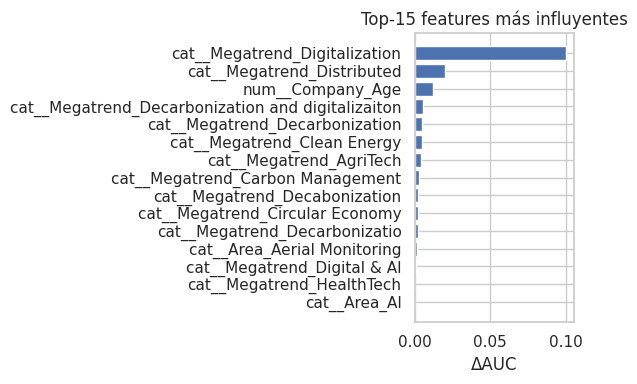

In [81]:
#IMPORTANCIA DE FEATURES
perm = permutation_importance(
    logit_clf, X_te, y_te, n_repeats=10, random_state=42, scoring="roc_auc"
)
importances = perm.importances_mean
feat_names = logit_clf.named_steps["prep"].get_feature_names_out()
top_idx = importances.argsort()[-15:]

plt.figure(figsize=(6,4))
plt.barh(range(15), importances[top_idx])
plt.yticks(range(15), feat_names[top_idx])
plt.xlabel("ΔAUC")
plt.title("Top-15 features más influyentes")
plt.tight_layout()
plt.show()

In [82]:
#RECOMENDACIÓN TOP-20
df_res = df.loc[X_te.index].copy()
df_res["Prob_HighPotential"] = proba_te
df_top = df_res.sort_values("Prob_HighPotential", ascending=False).head(20)

cols = ["Prob_HighPotential", "Firm", "Megatrend", "Area", "Country",
        "Funding Status", "Total Funding Amount (USD)"]
display(Markdown("### Top-20 startups recomendadas"))
display(df_top[cols])


### Top-20 startups recomendadas

,Prob_HighPotential,Firm,Megatrend,Area,Country,Funding Status,Total Funding Amount (USD)
0,0.996955,ITOCHU (storage systems),Other,Energy Storage Systems,Japan,Public (TYO: 8001),8.710000e+10
350,0.968247,PureCycle Technologies,Other,Plastic Recycling,United States of America,Public (NASDAQ: PCT),4.000000e+08
155,0.946296,Climeon,Other,Geothermal Heat,Sweden,Public (Nasdaq First North),2.626500e+07
11,0.943313,Covanta,Other,Waste-to-Energy,United States of America,Acquired (EQ),NaN
83,0.941765,PowerCell Sweden,Other,Hydrogen Fuel Cells,Sweden,Public (STO: PCELL),1.442000e+08
52,0.894360,Orsted (innovación),Other,Offshore Wind,Denmark,Public (CPH: ORSTED),5.285000e+10
135,0.785951,Nest Labs,Other,Smart Thermostats,United States of America,Acquired (Google),3.200000e+09
64,0.758012,Enovix,Digital & AI,Battery Innovation,United States of America,Public (NASDAQ: ENVX),NaN
338,0.669024,Lilium,Other,Electric Aviation,Germany,Public (NASDAQ: LILM),1.000000e+09
293,0.666697,Remix (Via),Other,EV Software,United States of America,Acquired (Via),2.700000e+07


In [83]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [84]:
models = {
    "Logistic":   LogisticRegression(max_iter=1000, C=1.0),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN":        KNeighborsClassifier(),
    "SVC":        SVC(kernel="rbf", probability=True, random_state=42),
    "GaussianNB": GaussianNB(),          # NB ignora escala
    "GradBoost":  GradientBoostingClassifier(random_state=42)
}

results = []

for name, clf in models.items():
    pipe = Pipeline([("prep", prep), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe, "predict_proba") \
           else pipe.decision_function(X_te)
    auc  = roc_auc_score(y_te, proba)
    top20 = proba.argsort()[::-1][:20]
    prec20 = precision_score(y_te[top20], np.ones(20))
    results.append((name, auc, prec20))
    print(f"{name:12}  AUC={auc:.3f}  Prec@20={prec20:.2f}")


Logistic      AUC=0.846  Prec@20=0.75
DecisionTree  AUC=0.690  Prec@20=0.75
KNN           AUC=0.782  Prec@20=0.65
SVC           AUC=0.850  Prec@20=0.85
GaussianNB    AUC=0.621  Prec@20=0.20
GradBoost     AUC=0.849  Prec@20=0.85


In [85]:
df_res = pd.DataFrame(results, columns=["Model","AUC","P20"])\
          .sort_values("AUC", ascending=False)
best_two = df_res.head(2)["Model"].tolist()
print("\nTop-2 modelos para ajuste fino:", best_two)


Top-2 modelos para ajuste fino: ['SVC', 'GradBoost']


In [86]:
search_spaces = {
    "DecisionTree": {
        "clf__max_depth": randint(2, 20),
        "clf__min_samples_split": randint(2, 20)
    },
    "GradBoost": {
        "clf__n_estimators": randint(50, 400),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__max_depth": randint(2, 6)
    },
    "SVC": {
        "clf__C": uniform(0.1, 10),
        "clf__gamma": ["scale", "auto"]
    },
    "KNN": {
        "clf__n_neighbors": randint(3, 30),
        "clf__weights": ["uniform", "distance"]
    }
}

best_pipes = {}

for name in best_two:
    if name not in search_spaces:
        raise ValueError(f"No hay espacio de búsqueda definido para {name}")

    base_clf = models[name]
    pipe = Pipeline([("prep", prep), ("clf", base_clf)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=search_spaces[name],
        n_iter=20,
        cv=5,
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_tr, y_tr)

    best_pipes[name] = search.best_estimator_

    print(f"\n>>> {name} – mejores hiperparámetros:")
    for k, v in search.best_params_.items():
        print(f"    {k}: {v}")

    if hasattr(search.best_estimator_, "predict_proba"):
        proba = search.predict_proba(X_te)[:, 1]
    else:
        proba = search.decision_function(X_te)

    tuned_auc = roc_auc_score(y_te, proba)
    print(f"{name} – AUC ajustado: {tuned_auc:.3f}")



>>> SVC – mejores hiperparámetros:
    clf__C: 3.845401188473625
    clf__gamma: scale
SVC – AUC ajustado: 0.858

>>> GradBoost – mejores hiperparámetros:
    clf__learning_rate: 0.17898646535366178
    clf__max_depth: 3
    clf__n_estimators: 314
GradBoost – AUC ajustado: 0.840


In [87]:
final_name = max(best_pipes,
                 key=lambda n: roc_auc_score(
                     y_te,
                     best_pipes[n].predict_proba(X_te)[:,1]
                     if hasattr(best_pipes[n],"predict_proba")
                     else best_pipes[n].decision_function(X_te)
                 )
)
final_model = best_pipes[final_name]
print(f"\nModelo final elegido ➜ {final_name}")


Modelo final elegido ➜ SVC


In [88]:
for n, pipe in best_pipes.items():
    proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe,"predict_proba") \
           else pipe.decision_function(X_te)
    auc = roc_auc_score(y_te, proba)
    top20 = proba.argsort()[::-1][:20]
    prec20 = precision_score(y_te[top20], np.ones(20))
    print(f"{n:12}  AUC={auc:.3f}  Prec@20={prec20:.2f}")

SVC           AUC=0.858  Prec@20=0.80
GradBoost     AUC=0.840  Prec@20=0.85


¿Por qué elegimos el SVC como modelo individual final?

La Métrica principal acordada AUC-ROC mide la capacidad de ordenar start-ups “buenas” frente a “malas” en todo el rango de umbrales.

Para el Rendimiento, el SVC alcanza la AUC más alta (0 .858), superando a Logistic (+0.012) y a GradBoost (+0.018).

El Valor de negocio, mantiene un Precision @ 20 del 80 %; es decir, de las 20 start-ups recomendadas, 16 son realmente de alto potencial.

Para la Complejidad vs. ganancia, el coste de cómputo (18 s) es razonable y el modelo es fácilmente serializable para producción.